In [56]:
import pandas as pd
import re
import spacy
import plac
from pathlib import Path
from spacy.util import minibatch, compounding
from __future__ import unicode_literals, print_function
import csv
import src.dataready as dataready
import src.train as train

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import savefig

In [7]:
df = pd.read_csv('src/data.csv',)

In [28]:
with open('src/data.csv', 'r') as file:
    rea = csv.reader(file,delimiter='\t')
    for row in rea:
        print(row)

In [33]:
csv.DictReader(open('src/data.csv'))

In [34]:
categories = {
    'CHARACTERS': ['character', 'characters', 'Arthur Fleck', 'Murray Franklin', 'Sophie Dumond', 'Penny Fleck', 'mother', 'mum'],
    'TALENT': ['actor', 'actress', 'actors', 'talent', 'director', 'Joaquin Phoenix', '#JoaquinPhoenix', 'Robert De Niro', 'Zazie Beetz', 'Frances Conroy', 'Todd Philips'],
    'PLOT': ['plot', 'frame', 'scene', 'scenes'],
    'TICKETS': ['ticket', 'tickets', 'presale'],
    'SOUNDTRACK': ['music', 'song'],
    'SPECIAL EFFECTS': ['FX', 'visual effects', 'graphics', 'postproduction'],
    'COSTUME DESIGN': ['costum', 'costumes', 'costume designer'],
    'HYPE': ['hype', 'hyyyype', 'amazing', 'awesome', 'desire', 'desires', 'premiere', 'Cant wait'],
    'BOX OFFICE': ['box office'],
    'REVIEWS': ['review', 'reviews'],
    'TRAILER':['trailer', 'trailers']
}

In [ ]:
categ = pd.DataFrame(categories)
categ.to_pkl

In [40]:
import pickle
# write python dict to a file

output = open('myfile.pkl', 'wb')
pickle.dump(categories, output)
output.close()
# read python dict back from the file
pkl_file = open('myfile.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

In [79]:
df = pd.read_csv('predicted.csv')

In [87]:
categories = df['category'].value_counts()

In [91]:
categories

TALENT        3022
HYPE           518
CHARACTERS     410
REVIEWS        278
TICKETS         82
BOX OFFICE      44
TRAILER         37
PLOT             2
Name: category, dtype: int64

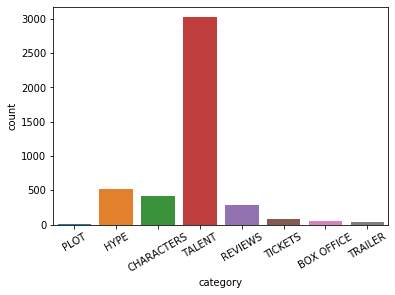

In [95]:
p = sns.countplot(data=df, x = 'category')
plt.xticks(rotation=30)
plt.savefig('output/barcategories')

In [70]:
def volumeCategories(pathcsv, serie):
    df = pd.read_csv(pathcsv)
    v = df[serie].value_counts()
    return v

In [96]:
df = pd.read_csv('predicted.csv')

In [99]:
df['text'].count()

20764

In [101]:
df['category'].count()/df['text'].count()

0.21156809863224812